In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.distributions import Normal as norm
from termcolor import colored
from sklearn.decomposition import PCA
from scipy import linalg as LA
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import multinomial
from scipy.stats import logistic
import random
from Main_functions import *

In [2]:
def pre_process(X_raw_T, X_raw_Test, Type = 'normalizing'):
    
    X_new_T = (X_raw_T - X_raw_T.mean(axis = 0))
    X_new_Test = (X_raw_Test - X_raw_T.mean(axis = 0))
    
    if Type == 'normalizing':
        std = X_new_T.std(axis = 0)
        for i in range(len(std)):
            if std[i] > 1e-3:
                X_new_T[:, i] /= std[i]
                X_new_Test[:, i] /= std[i]
        
    elif Type == 'center_scaling':
        Max = X_new_T.max(axis = 0)
        Min = X_new_T.min(axis = 0)
        for i in range(len(Max)):
            if Max[i] - Min[i] > 1e-3:
                X_new_T[:, i]  = (X_new_T[:, i] - Min[i])/(Max[i] - Min[i])
                X_new_Test[:, i]  = (X_new_Test[:, i] - Min[i])/(Max[i] - Min[i])
            else: 
                X_new_T[:, i]  = (X_new_T[:, i] - Min[i])
                X_new_Test[:, i]  = (X_new_Test[:, i] - Min[i])
                
    return X_new_T, X_new_Test

In [3]:
train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")

In [4]:
# Get Number of records and columns
print(train.shape)
train.head(5)

(103904, 25)


,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [5]:
# Drop unnecessary columns
train = train.drop('Unnamed: 0', axis=1)
train = train.drop('id', axis=1)
# Check size of the data set
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  object 
 1   Customer Type                      103904 non-null  object 
 2   Age                                103904 non-null  int64  
 3   Type of Travel                     103904 non-null  object 
 4   Class                              103904 non-null  object 
 5   Flight Distance                    103904 non-null  int64  
 6   Inflight wifi service              103904 non-null  int64  
 7   Departure/Arrival time convenient  103904 non-null  int64  
 8   Ease of Online booking             103904 non-null  int64  
 9   Gate location                      103904 non-null  int64  
 10  Food and drink                     103904 non-null  int64  
 11  Online boarding                    1039

In [6]:
# Get Number of records and columns
print(train.shape)
train.head(5)

(103904, 23)


,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [7]:
# Get Number of records and columns
print(test.shape)
test.head(5)

(25976, 25)


,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [8]:
# Drop unnecessary columns
test = test.drop('Unnamed: 0', axis=1)
test = test.drop('id', axis=1)
# Check size of the data set
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25976 entries, 0 to 25975
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             25976 non-null  object 
 1   Customer Type                      25976 non-null  object 
 2   Age                                25976 non-null  int64  
 3   Type of Travel                     25976 non-null  object 
 4   Class                              25976 non-null  object 
 5   Flight Distance                    25976 non-null  int64  
 6   Inflight wifi service              25976 non-null  int64  
 7   Departure/Arrival time convenient  25976 non-null  int64  
 8   Ease of Online booking             25976 non-null  int64  
 9   Gate location                      25976 non-null  int64  
 10  Food and drink                     25976 non-null  int64  
 11  Online boarding                    25976 non-null  int

In [9]:
# Get Number of records and columns
print(test.shape)
test.head(5)

(25976, 23)


,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [10]:
#Replace spaces in the column names with underscore - Train and Test

train.columns = [c.replace(' ', '_') for c in train.columns]
test.columns = [c.replace(' ', '_') for c in test.columns]

In [11]:
train['satisfaction'].replace({'neutral or dissatisfied': 0, 'satisfied': 1},inplace = True)
test['satisfaction'].replace({'neutral or dissatisfied': 0, 'satisfied': 1},inplace = True)

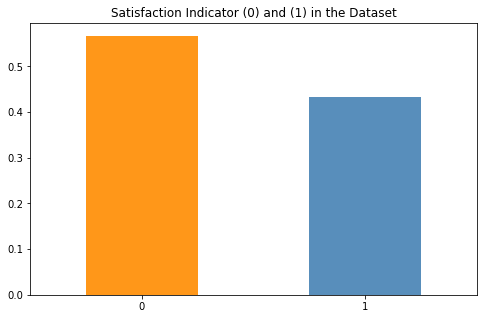

In [12]:
fig = plt.figure(figsize = (8,5))
train.satisfaction.value_counts(normalize = True).plot(kind='bar', color= ['darkorange','steelblue'], alpha = 0.9, rot=0)
plt.title('Satisfaction Indicator (0) and (1) in the Dataset')
plt.show()

In [13]:
train.head()

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,0
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,0
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,0
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1


In [14]:
train['Customer_Type'].unique()

array(['Loyal Customer', 'disloyal Customer'], dtype=object)

In [15]:
train['Customer_Type'].replace({'Loyal Customer': 1, 'disloyal Customer': 0},inplace = True)
test['Customer_Type'].replace({'Loyal Customer': 1, 'disloyal Customer': 0},inplace = True)

In [16]:
train.head()

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,Male,1,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,0
1,Male,0,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,0
2,Female,1,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,Female,1,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,0
4,Male,1,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1


In [17]:
train['Gender'].unique()

array(['Male', 'Female'], dtype=object)

In [18]:
train['Gender'].replace({'Male': 0, 'Female': 1},inplace = True)
test['Gender'].replace({'Male': 0, 'Female': 1},inplace = True)

In [19]:
train['Type_of_Travel'].unique()

array(['Personal Travel', 'Business travel'], dtype=object)

In [20]:
train['Type_of_Travel'].replace({'Personal Travel': 0, 'Business travel': 1},inplace = True)
test['Type_of_Travel'].replace({'Personal Travel': 0, 'Business travel': 1},inplace = True)

In [21]:
train['Class'].unique()

array(['Eco Plus', 'Business', 'Eco'], dtype=object)

In [22]:
y = pd.get_dummies(train.Class, prefix='Class')
print(y.head())

   Class_Business  Class_Eco  Class_Eco Plus
0               0          0               1
1               1          0               0
2               1          0               0
3               1          0               0
4               1          0               0


In [23]:
train[['Class_Business',  'Class_Eco',  'Class_Eco Plus']] = y[['Class_Business',  'Class_Eco',  'Class_Eco Plus']]

In [24]:
y_t = pd.get_dummies(test.Class, prefix='Class')
print(y.head())

   Class_Business  Class_Eco  Class_Eco Plus
0               0          0               1
1               1          0               0
2               1          0               0
3               1          0               0
4               1          0               0


In [25]:
test[['Class_Business',  'Class_Eco',  'Class_Eco Plus']] = y_t[['Class_Business',  'Class_Eco',  'Class_Eco Plus']]

In [26]:
train.drop(columns=["Class"], inplace=True)
test.drop(columns=["Class"], inplace=True)

In [27]:
train.head()

,Gender,Customer_Type,Age,Type_of_Travel,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,...,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction,Class_Business,Class_Eco,Class_Eco Plus
0,0,1,13,0,460,3,4,3,1,5,...,4,4,5,5,25,18.0,0,0,0,1
1,0,0,25,1,235,3,2,3,3,1,...,3,1,4,1,1,6.0,0,1,0,0
2,1,1,26,1,1142,2,2,2,2,5,...,4,4,4,5,0,0.0,1,1,0,0
3,1,1,25,1,562,2,5,5,5,2,...,3,1,4,2,11,9.0,0,1,0,0
4,0,1,61,1,214,3,3,3,3,4,...,4,3,3,3,0,0.0,1,1,0,0


In [28]:
# train['Class'].replace({'Business': 2, 'Eco Plus': 1, 'Eco':0},inplace = True)
# test['Class'].replace({'Business': 2, 'Eco Plus': 1, 'Eco':0},inplace = True)

In [29]:
test.head()

,Gender,Customer_Type,Age,Type_of_Travel,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,...,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction,Class_Business,Class_Eco,Class_Eco Plus
0,1,1,52,1,160,5,4,3,4,3,...,5,2,5,5,50,44.0,1,0,1,0
1,1,1,36,1,2863,1,1,3,1,5,...,4,3,4,5,0,0.0,1,1,0,0
2,0,0,20,1,192,2,0,2,4,2,...,3,2,2,2,0,0.0,0,0,1,0
3,0,1,44,1,3377,0,0,0,2,3,...,1,3,1,4,0,6.0,1,1,0,0
4,1,1,49,1,1182,2,3,4,3,4,...,2,4,2,4,0,20.0,1,0,1,0


In [30]:
train.shape

(103904, 25)

In [31]:
train.dropna(inplace=True)

In [32]:
train.shape

(103594, 25)

In [33]:
test.dropna(inplace=True)

In [34]:
test.shape

(25893, 25)

In [35]:
Type = 'center_scaling'

In [36]:
# Type = 'normalizing'

In [37]:
X_train = np.array(train.drop(columns=["satisfaction"], inplace = False))
X_test = np.array(test.drop(columns=["satisfaction"], inplace = False))

In [38]:
train_processed, test_processed = pre_process(X_train, 
                                              X_test, 
                                              Type = Type) 
train_processed.shape, test_processed.shape

((103594, 24), (25893, 24))

In [39]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(X_train)
train_processed=scaler.transform(X_train)
test_processed=scaler.transform(X_test)

In [40]:
n, d = train_processed.shape

In [41]:
D_T = np.array(train['satisfaction'])
D_test = np.array(test['satisfaction'])

In [42]:
D_T.shape, D_test.shape

((103594,), (25893,))

In [43]:
X_T = torch.tensor(train_processed, dtype = torch.float64)
Y_T = torch.tensor(np.zeros(train_processed.shape), dtype = torch.float64)
D_T = torch.tensor(D_T, dtype = torch.torch.int64)

In [44]:
X_test = torch.tensor(test_processed, dtype = torch.float64)
Y_test = torch.tensor(np.zeros(test_processed.shape), dtype = torch.float64)
D_test = torch.tensor(D_test, dtype = torch.torch.int64)

In [45]:
X_test.shape, X_T.shape

(torch.Size([25893, 24]), torch.Size([103594, 24]))

In [46]:
d = X_T.shape[1] 
k = d
n_labels = 2

In [47]:
model = ML(d, k, n_labels, 
           X_T, Y_T,  D_T, D_T, 
           X_test, Y_test, D_test, D_test, 
           Type = 'HS')

In [48]:
model.train(learning_rate = 4.5e-2, #4e-2 --> 93%
            n_iters = 20001, 
            decay = 0.95)

Starting Tau:  tensor([0.7991], dtype=torch.float64, requires_grad=True)
epoch 0: loss = 0.4096700464801286
train accuracy with noise 0.5666061741027473
train accuracy without noise 0.5666061741027473
test accuracy with noise 0.561078283706021
test accuracy without noise 0.561078283706021
epoch 5000:
 norm of B.grad = 0.00021392341251718887,
 loss = -0.24830525404309
tensor([3.0345], dtype=torch.float64, requires_grad=True)
train accuracy with noise 0.9186149777014113
train accuracy without noise 0.9186149777014113
test accuracy with noise 0.9175066620322094
test accuracy without noise 0.9175066620322094
epoch 10000:
 norm of B.grad = 4.0781945803599876e-05,
 loss = -0.2671021560376223
tensor([3.5368], dtype=torch.float64, requires_grad=True)
train accuracy with noise 0.9251307990810279
train accuracy without noise 0.9251307990810279
test accuracy with noise 0.9239176611439385
test accuracy without noise 0.9239176611439385
epoch 15000:
 norm of B.grad = 2.414992674329666e-05,
 loss = -

In [49]:
M = (model.B @ model.B.T).detach().numpy()

In [50]:
_, eigs, _ = LA.svd(M, full_matrices=False)

In [51]:
eigs

array([1.97533575e+01, 1.34234856e+01, 1.63214425e+00, 8.24322609e-01,
       5.49944526e-08, 6.88962504e-09, 1.74732818e-09, 5.43365346e-10,
       2.10779730e-10, 7.74579563e-11, 7.20196323e-11, 2.20060618e-11,
       1.59118656e-11, 8.92331774e-12, 3.82481914e-12, 3.00263583e-12,
       1.21497146e-12, 3.05743397e-13, 1.14893423e-14, 1.87871481e-15,
       5.04653480e-16, 2.73729561e-16, 1.20264085e-16, 1.06376330e-16])

### Covariance of the data

In [52]:
C = np.cov(train_processed.T)
U_c, D_C, V_c = LA.svd(C, full_matrices = False)
D_C

array([6.03628685e-01, 2.59553323e-01, 2.47894954e-01, 1.96343146e-01,
       1.77371965e-01, 1.56012136e-01, 1.01183783e-01, 8.20688026e-02,
       6.87208522e-02, 5.50632316e-02, 4.79916854e-02, 3.78637295e-02,
       3.61983635e-02, 3.39909980e-02, 2.97523521e-02, 2.69570379e-02,
       2.32664854e-02, 2.23693290e-02, 2.04666759e-02, 1.84004143e-02,
       1.25066182e-02, 1.14028641e-03, 2.01669522e-05, 3.31508332e-16])

In [53]:
sqrt_C_inv = U_c @ np.diag(np.sqrt(D_C)**-1) @ V_c
sqrt_C = U_c @ np.diag(np.sqrt(D_C)) @ V_c

In [54]:
train_processed_normal = train_processed @ sqrt_C_inv

In [55]:
test_processed_normal = test_processed @ sqrt_C_inv

In [56]:
# X_train = np.array(train.drop(columns=["satisfaction"], inplace = False))
# X_test = np.array(test.drop(columns=["satisfaction"], inplace = False))
D_T = np.array(train['satisfaction'])
D_test = np.array(test['satisfaction'])

In [57]:
# D_T = np.array(train)[
# D_test = np.array(test)[:, -1]

X_T = torch.tensor(train_processed, dtype = torch.float64)
Y_T = torch.tensor(np.zeros(train_processed.shape), dtype = torch.float64)
D_T = torch.tensor(D_T, dtype = torch.torch.int64)

X_test = torch.tensor(test_processed, dtype = torch.float64)
Y_test = torch.tensor(np.zeros(test_processed.shape), dtype = torch.float64)
D_test = torch.tensor(D_test, dtype = torch.torch.int64)

In [58]:
model_normal = ML(d, k, n_labels, 
           X_T, Y_T,  D_T, D_T, 
           X_test, Y_test, D_test, D_test, Type = 'HS')

In [59]:
model_normal.train(learning_rate = 1e-3, 
            n_iters = 5001, 
            decay = 0.95)

Starting Tau:  tensor([0.5711], dtype=torch.float64, requires_grad=True)
epoch 0: loss = 0.3157297904821243
train accuracy with noise 0.5666061741027473
train accuracy without noise 0.5666061741027473
test accuracy with noise 0.561078283706021
test accuracy without noise 0.561078283706021
epoch 5000:
 norm of B.grad = 0.007130836137883966,
 loss = -0.025999783570045832
tensor([0.8220], dtype=torch.float64, requires_grad=True)
train accuracy with noise 0.8163503677819178
train accuracy without noise 0.8163503677819178
test accuracy with noise 0.8110686285868768
test accuracy without noise 0.8110686285868768
